# ETL de Mensagens do Telegram: da Extração JSON à Análise com AWS Athena



Este projeto implementa uma pipeline de dados ponta a ponta para coletar e processar mensagens de um bot do Telegram, transformando dados brutos JSON em um formato otimizado (Parquet). O projeto utiliza serviços da AWS como Lambda, S3 e Athena para automação, armazenamento eficiente e análise de dados, permitindo a extração de insights valiosos.

Fluxograma do projeto:

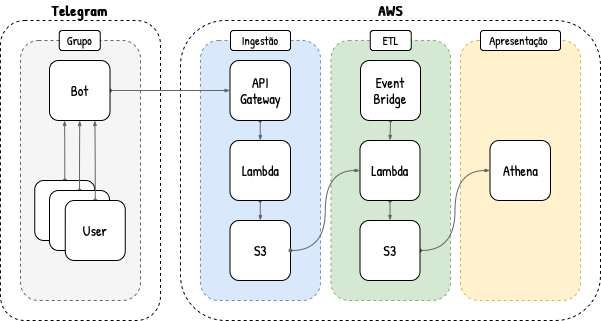

### Projetos e Perfis

**Projeto:**

* Kaggle: [link](https://www.kaggle.com/code/thiagomartinslk/etl-de-mensagens-do-telegram/edit)

* Github: [link](https://github.com/ThiagoMSLK/projects)

**Meus perfis:**

* Kaggle: [link](https://www.kaggle.com/thiagomartinslk)

* Github: [link](https://github.com/ThiagoMSLK)

* Linkedin: [link](https://www.linkedin.com/in/thiagomartinslk)

## 1 - Criando e configurando o bot no Telegram para coleta de dados






### 1 - Criando o Bot

1. Procure por BotFather na lista de contatos do Telegram.

2. Digite `/start` na conversa com o BotFather.

3. Em seguida, digite `/newbot`.

4. Escolha um nome para o bot. No nosso caso, será "Project_Bot".

5. Defina um nome de usuário para o bot. É importante lembrar que o nome de usuário deve terminar com a palavra "bot". No nosso caso (e após várias tentativas por causa: "Este nome de usuário já está em uso"), escolhemos "Prime_Shelby_bot".

6. Após definir o nome de usuário, você receberá um **token** de acesso à API HTTP, que permitirá a comunicação com o bot.

7. Procure pelo seu bot (Project_Bot) na lista de contatos e inicie uma conversa com o comando `/start`.

8. Crie um grupo e adicione o bot como administrador. Você pode deixá-lo sem nenhuma permissão específica, se preferir.

9. Adicione outros usuários comuns ao grupo. A partir deste ponto, o bot começará a coletar todas as mensagens do grupo e poderá ser acessado utilizando o token da API.






***Caso seja necessário conferir novamente o token:***

1. Volte para a conversa com o BotFather.

2. Digite o comando `/mybots`.

3. Selecione o nome de usuário do seu bot.

4. Em seguida, clique na opção “API Token” para visualizar o token de acesso.

### 2 - Configurando o Bot para não ingressar em novos grupos

1. Volte para a conversa com o BotFather.

2. Digite `/mybots`.

3. Selecione o bot pelo nome de usuário.

4. Escolha **Bot Settings**.

5. Selecione **Allow Groups?**

6. Escolha a opção **Turn Groups Off**.

**Observação**: Após remover a permissão para o bot ingressar em novos grupos, ele não poderá mais ser adicionado a outros grupos do Telegram. No entanto, ele continuará participando normalmente dos grupos dos quais já é membro.

## 2 - Testando o Bot

### 1 - Testando a API

Vamos usar o `getpass` para trabalhar com informações sigilosas com segurança.



In [ ]:
from getpass import getpass
token = getpass()

··········


Para facilitar e evitar repetição de código, vamos criar duas funções:

* `get_me` → responsável por solicitar as informações do bot.

* `get_updates` → responsável por solicitar as mensagens das últimas 24 horas.

Vale destacar que o Telegram guarda as mensagens recebidas pelo bot apenas pelas últimas 24 horas. Após esse período, elas são excluídas. Portanto, se não forem coletadas dentro desse prazo, os dados poderão ser perdidos.

In [ ]:
import json
import requests
from datetime import datetime

BOT_URL = f"https://api.telegram.org/bot{token}"

#  Responsável por solicitar as informações do bot.
def get_me():
    get_me_url = f"{BOT_URL}/getMe"
    response = requests.get(get_me_url)
    return response.json()

# Responsável por solicitar as mensagens das últimas 24 horas.
def get_updates():
    get_updates_url = f"{BOT_URL}/getUpdates"
    response = requests.get(get_updates_url)
    return response.json()

# Verificando as informações do bot
get_me()

{'ok': True,
 'result': {'id': 7705860577,
  'is_bot': True,
  'first_name': 'Project_Bot',
  'username': 'Prime_Shelby_bot',
  'can_join_groups': False,
  'can_read_all_group_messages': False,
  'supports_inline_queries': False,
  'can_connect_to_business': False,
  'has_main_web_app': False}}

Vou enviar uma mensagem no grupo com a palavra "teste" para verificar o recebimento pelo bot. Essa ação me retornará um arquivo JSON.

In [ ]:
get_updates()

{'ok': True,
 'result': [{'update_id': 299215786,
   'message': {'message_id': 65,
    'from': {'id': 6693529850,
     'is_bot': False,
     'first_name': 'Thiago',
     'language_code': 'pt-br'},
    'chat': {'id': -1002855453029,
     'title': 'Project Bot',
     'type': 'supergroup'},
    'date': 1759294266,
    'text': 'teste'}}]}

**Entendendo o JSON no Python**

Para simplificar, a biblioteca JSON do Python trata os arquivos JSON como um dicionário, que é um tipo de lista organizada que o próprio Python usa. Se quiser saber mais sobre isso, clique no [link](https://docs.python.org/pt-br/3/tutorial/datastructures.html).

Como você pode ver, o resultado anterior ficou muito confuso, com as informações amontoadas (ou, no termo técnico, dicionários aninhados). Para que a leitura seja mais fácil e as informações fiquem separadas, vamos formatar o JSON.


In [ ]:
updates = get_updates()
print(json.dumps(updates, indent=2))

{
  "ok": true,
  "result": [
    {
      "update_id": 299215786,
      "message": {
        "message_id": 65,
        "from": {
          "id": 6693529850,
          "is_bot": false,
          "first_name": "Thiago",
          "language_code": "pt-br"
        },
        "chat": {
          "id": -1002855453029,
          "title": "Project Bot",
          "type": "supergroup"
        },
        "date": 1759294266,
        "text": "teste"
      }
    }
  ]
}


Agora que enviei múltiplas mensagens, vamos testar a extração da primeira mensagem do dia, buscando o nome do usuário, o conteúdo da mensagem e a data/hora em que ela foi enviada.



In [ ]:
data = get_updates()

# A primeira linha do código define qual mensagem do dia será selecionada. O índice 0 corresponde à primeira mensagem, o 1 à segunda, e assim sucessivamente.
first_message = data['result'][0]

# As próximas três linhas selecionam o conteúdo desejado do JSON. Seguindo essa estrutura, é possível selecionar qualquer conteúdo que for do seu interesse.
print(first_message['message']['from']['first_name'])
print(datetime.fromtimestamp(first_message['message']['date']))
print(first_message['message']['text'])

Thiago
2025-10-01 04:51:06
teste


### 2 - Consumindo os Dados Coletados pela API



**Avançando para a Complexidade**

Agora, vamos complexificar um pouco. O código abaixo seleciona os dados e informações que serão armazenados em um Bucket do AWS S3.

Similar ao código anterior, ele seleciona uma parte específica do arquivo JSON. Porém, ao contrário do primeiro código, que exibia poucos dados de apenas uma mensagem, este código extrai uma quantidade maior de dados de múltiplas mensagens e os armazena em um novo dicionário chamado `parsed_data`.

Um código similar a este será usado mais adiante no projeto.

In [ ]:
date = datetime.now().strftime('%Y-%m-%d')
timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')


parsed_data = dict()
count = 0
for message in data['result']:

  count = count + 1
  print(f'\n Mensagem - {count}\n') # Contar as mensagens nas ultimas 24 horas foram recebidas.
  message_data = message['message']

  for key, value in message_data.items():

      if key == 'from':
          for k, v in message_data[key].items():
              if k in ['id', 'is_bot', 'first_name']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key == 'chat':
          for k, v in message_data[key].items():
              if k in ['id', 'type']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key in ['message_id', 'date', 'text']:
          parsed_data[key] = [value]

  if not 'text' in parsed_data.keys():
    parsed_data['text'] = [None]

  parsed_data['context_date'] = [date]
  parsed_data['context_timestamp'] = [timestamp]

  for k, v in parsed_data.items():
    print(f"{k}: {v}")


 Mensagem - 1

message_id: [65]
user_id: [6693529850]
user_is_bot: [False]
user_first_name: ['Thiago']
chat_id: [-1002855453029]
chat_type: ['supergroup']
date: [1759294266]
text: ['teste']
context_date: ['2025-10-01']
context_timestamp: ['2025-10-01 04:51:57']

 Mensagem - 2

message_id: [66]
user_id: [6693529850]
user_is_bot: [False]
user_first_name: ['Thiago']
chat_id: [-1002855453029]
chat_type: ['supergroup']
date: [1759294291]
text: ['teste']
context_date: ['2025-10-01']
context_timestamp: ['2025-10-01 04:51:57']

 Mensagem - 3

message_id: [67]
user_id: [6693529850]
user_is_bot: [False]
user_first_name: ['Thiago']
chat_id: [-1002855453029]
chat_type: ['supergroup']
date: [1759294294]
text: ['mais testes']
context_date: ['2025-10-01']
context_timestamp: ['2025-10-01 04:51:57']

 Mensagem - 4

message_id: [68]
user_id: [6693529850]
user_is_bot: [False]
user_first_name: ['Thiago']
chat_id: [-1002855453029]
chat_type: ['supergroup']
date: [1759294300]
text: ['testes']
context_date:

Os arquivos serão armazenados no S3 no formato Parquet, pois é mais leve e eficiente. Por isso, usaremos a biblioteca PyArrow, que é específica para este formato de arquivo.

Embora o Pandas também seja capaz de ler Parquet, ele é uma biblioteca mais generalista. Portanto, neste tipo de caso, o Pandas é menos eficiente e rápido que o PyArrow.

Então, vamos ver como o arquivo será armazenado e lido. Esclareço que o AWS Athena será o responsável pela leitura. Por isso, não vamos nos aprofundar nisso, apenas mostrando o resultado, já que mais adiante no projeto usaremos o PyArrow.

In [ ]:
import pyarrow as pa

table = pa.Table.from_pydict(parsed_data) # Vamos usar o dicionário criado acima para criar a tabela do PyArrow.

In [ ]:
table # Exibir tabela

pyarrow.Table
message_id: int64
user_id: int64
user_is_bot: bool
user_first_name: string
chat_id: int64
chat_type: string
date: int64
text: string
context_date: string
context_timestamp: string
----
message_id: [[73]]
user_id: [[6693529850]]
user_is_bot: [[false]]
user_first_name: [["Thiago"]]
chat_id: [[-1002855453029]]
chat_type: [["supergroup"]]
date: [[1759294305]]
text: [["bb"]]
context_date: [["2025-10-01"]]
context_timestamp: [["2025-10-01 04:51:57"]]

## 3 -  Ingestão do Dados

### 1 - AWS Bucket S3

Criar um bucket no S3 para armazenar os dados da API

1 - Acesse o Console da AWS.

2 - Vá até o serviço Amazon S3.

3 - Clique em Create bucket.

4 - Defina um nome único para o bucket com o sufixo raw ou bronze (ex.: meu-bucket-dados-api-raw).

5 - Escolha a região desejada (de preferência próxima a onde os dados serão processados, ex.: sa-east-1 para São Paulo).

6 - Configure as opções de permissões conforme necessário (padrão: bloqueio de acesso público ativado).

7 - Clique em Create bucket.

Agora o bucket está pronto para receber os dados coletados da API.

### 2 - AWS Lambda

Criar uma função Lambda para receber os dados e armazená-los no bucket do S3
________________________________________________________________________________


1 - Crie a função no AWS Lambda, no "Tempo de execução" escolha o Python 3.12.

2 - No código da função, cole o script abaixo e não se esqueça de realizar o deploy do código.

3 - Defina a variável de ambiente BUCKET com o nome do bucket criado.

4 - Defina a variável de ambiente TELEGRAM_CHAT_ID com o ID do grupo do Telegram.

5 - Conceda permissão à Lambda para gravar no S3:

6 - Na role da Lambda, adicione a política AmazonS3FullAccess (ou, para mais segurança, crie uma política customizada permitindo apenas s3:PutObject).

7 - Teste a função enviando um evento no formato JSON pelo console da Lambda.

```python
import os
import json
import logging
from datetime import datetime, timezone, timedelta

import boto3


def lambda_handler(event: dict, context: dict) -> dict:

  '''
  Recebe uma mensagens do Telegram via AWS API Gateway, verifica no
  seu conteúdo se foi produzida em um determinado grupo e a escreve,
  em seu formato original JSON, em um bucket do AWS S3.
  '''

  # vars de ambiente

  BUCKET = os.environ['AWS_S3_BUCKET'] # Variável de ambiente com o nome do bucket do S3.
  TELEGRAM_CHAT_ID = int(os.environ['TELEGRAM_CHAT_ID']) # Variável de ambiente com o ID do grupo, para que ele colete apenas os dados desse grupo/chat.

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3)) # Definir o UTC padrão como -3, correspondente ao horário de Brasília.
  date = datetime.now(tzinfo).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  filename = f'{timestamp}.json'

  # código principal

  client = boto3.client('s3')
  
  try:

    message = json.loads(event["body"])
    # message = event # Para testes
    chat_id = message["message"]["chat"]["id"]

    if chat_id == TELEGRAM_CHAT_ID:

      with open(f"/tmp/{filename}", mode='w', encoding='utf8') as fp:
        json.dump(message, fp)

      client.upload_file(f'/tmp/{filename}', BUCKET, f'telegram/context_date={date}/{filename}')

  except Exception as exc:
      logging.error(msg=exc)
      return dict(statusCode="500")

  else:
      return dict(statusCode="200")
```


### 3 - AWS API Gateway

Criar uma API com o API Gateway
________________________________________________________________________________


1 - Clique em **"Criar API"**, depois em **"API REST"** e em seguida clique em **"Compilar"**.

2 - Escolha **"Nova API"** e defina um nome para a API.

3 - Clique em **"Criar método"**.

4 - Em **"Tipo de método"**, selecione **"POST"**.

5 - Em **"Tipo de integração"**, selecione **"Função do Lambda"**.

6 - Ative a opção **"Integração do proxy do Lambda"**. Para fazer testes, talvez seja necessário desativar. Porém, para que a coleta das mensagens funcione, a opção precisa estar ativada — pelo menos foi assim no meu caso.

7 - Em **"Função do Lambda"**, selecione a função do Lambda criada anteriormente.

8 - Volte para a área de recursos da API criada e clique em **"Implantar API"**.

9 - Em **"Estágio"**, selecione **"Novo estágio"** ou escolha um já existente e depois clique em **"Implantar"**.

10 - Você receberá uma **URL de endpoint** para acessar a API.



In [ ]:
# Coloque aqui a URL de endpoint da API
aws_api_gateway_url = getpass()

··········


### 4 - Telegram

Configurar o Webhook.


In [ ]:
response = requests.get(url=f'{BOT_URL}/setWebhook?url={aws_api_gateway_url}')

print(json.dumps(json.loads(response.text), indent=2))

{
  "ok": true,
  "result": true,
  "description": "Webhook was set"
}


Verificar as informações sobre o Webhook estão corretas.

In [ ]:
response = requests.get(url=f'{BOT_URL}/getWebhookInfo')

print(json.dumps(json.loads(response.text), indent=2))

{
  "ok": true,
  "result": {
    "url": "https://deq6z15phj.execute-api.sa-east-1.amazonaws.com/dev",
    "has_custom_certificate": false,
    "pending_update_count": 6,
    "max_connections": 40,
    "ip_address": "18.231.47.168"
  }
}


Caso necessario excluir o Webhook.

In [ ]:
response = requests.get(url=f'{BOT_URL}/deleteWebhook?url={aws_api_gateway_url}')

print(json.dumps(json.loads(response.text), indent=2))

{
  "ok": true,
  "result": true,
  "description": "Webhook was deleted"
}


## 4 - ETL

### AWS Bucket S3

Na etapa de ETL, será necessário criar um novo bucket destinado ao armazenamento dos dados enriquecidos. Seguindo a mesma abordagem utilizada na fase de Ingestão de Dados, este bucket deve ser nomeado utilizando o sufixo enriched ou silver.

### AWS Lambda

Nesta etapa, vamos criar duas funções Lambda.
*   A **primeira** acessará os dados do primeiro bucket, transformará essas informações em um formato adequado para análises futuras e as armazenará em um novo bucket, possibilitando o acesso por meio do Athena.
*   A **segunda** será responsável por carregar as partições criadas pela primeira função, permitindo que o Athena reconheça automaticamente essas novas partições.


***Primeira Função***

Os seis primeiros passos serão semelhantes à etapa da função Lambda criada na parte de **Ingestão de Dados**.
________________________________________________________________________________
1 - Crie a função no AWS Lambda, no "Tempo de execução" escolha o Python 3.12.

2 - No código da função, cole o script abaixo e não se esqueça de realizar o deploy do código.

3 - Defina a variável de ambiente RAW_BUCKET com o nome do primeiro bucket criado.

4 - Defina a variável de ambiente ENRICHED_BUCKET  com o nome no ultimo bucket que criado.

5 - Conceda permissão à Lambda para gravar no S3:

6 - Na role da Lambda, adicione a política AmazonS3FullAccess (ou, para mais segurança, crie uma política customizada permitindo apenas s3:PutObject e s3:GetObject).

________________________________________________________________________________
**A partir deste ponto, começam as diferenças mais significativas.**
________________________________________________________________________________


7 - No console da função Lambda, vá em "Configuração" > "Configuração Geral", clique em "Editar" e defina o tempo limite para 5 minutos, já que, dependendo da quantidade de mensagens, a execução pode demorar e gerar erro.

8 - Como no código da função estamos usando o framework PyArrow, que não é nativo do Lambda da AWS, precisamos criar uma Layer (camada) para que a função consiga acessá-lo.

9 - Acesse [este link](https://github.com/aws/aws-sdk-pandas/releases)
 e faça o download do arquivo da versão correspondente ao Python configurado na função Lambda.

10 - Crie um bucket no S3 para armazenar o arquivo.

11 - Voltando para a função Lambda, desça até o final da página e clique em "Adicionar uma camada".

12 - Em "Origem da camada", clique na opção para criar uma nova camada.

13 - Nomeie a camada e, em seguida, escolha "Fazer upload de um arquivo do Amazon S3", informando o caminho completo do arquivo que foi baixado e armazenado no S3.

14 - Em "Runtimes compatíveis", selecione Python 3.12.

15 - Voltando em "Origem da camada", escolha "Camadas personalizadas" e selecione a camada que criamos.

```python
import os
import json
import logging
from datetime import datetime, timedelta, timezone

import boto3
import pyarrow as pa
import pyarrow.parquet as pq


def lambda_handler(event: dict, context: dict) -> bool:

  '''
  Diariamente é executado para compactar as diversas mensagensm, no formato
  JSON, do dia anterior, armazenadas no bucket de dados cru, em um único
  arquivo no formato PARQUET, armazenando-o no bucket de dados enriquecidos
  '''

  # vars de ambiente

  RAW_BUCKET = os.environ['AWS_S3_BUCKET']
  ENRICHED_BUCKET = os.environ['AWS_S3_ENRICHED']

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = (datetime.now(tzinfo) - timedelta(days=1)).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  # código principal

  table = None
  client = boto3.client('s3')

  try:

      response = client.list_objects_v2(Bucket=RAW_BUCKET, Prefix=f'telegram/context_date={date}')

      for content in response['Contents']:

        key = content['Key']
        client.download_file(RAW_BUCKET, key, f"/tmp/{key.split('/')[-1]}")

        with open(f"/tmp/{key.split('/')[-1]}", mode='r', encoding='utf8') as fp:

          data = json.load(fp)
          data = data["message"]

        parsed_data = parse_data(data=data)
        iter_table = pa.Table.from_pydict(mapping=parsed_data)

        if table:

          table = pa.concat_tables([table, iter_table])

        else:

          table = iter_table
          iter_table = None
          
      pq.write_table(table=table, where=f'/tmp/{timestamp}.parquet')
      client.upload_file(f"/tmp/{timestamp}.parquet", ENRICHED_BUCKET, f"telegram/context_date={date}/{timestamp}.parquet")

      return True
  
  except Exception as exc:
      logging.error(msg=exc)
      return False
```

```python
def parse_data(data: dict) -> dict:

  date = datetime.now().strftime('%Y-%m-%d')
  timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

  parsed_data = dict()

  for key, value in data.items():

      if key == 'from':
          for k, v in data[key].items():
              if k in ['id', 'is_bot', 'first_name']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key == 'chat':
          for k, v in data[key].items():
              if k in ['id', 'type']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key in ['message_id', 'date', 'text']:
          parsed_data[key] = [value]

  if not 'text' in parsed_data.keys():
    parsed_data['text'] = [None]

  return parsed_data
```

***Segunda Função***


Será tudo igual às últimas, porém a permissão atribuída será AmazonAthenaFullAccess. Entretanto, para que ela seja executada de forma automática após a execução da primeira função Lambda, será necessário realizar uma configuração adicional no primeiro Lambda.

1 - No "**Diagrama**", na parte superior do console, clique em "Adicio**nar destino**".

2 - Em "**Origem**", selecione "**Invocação assíncrona**".

3 - Em "**Condição**", selecione "**Em caso de sucesso**".

4 - Em "**Tipo de destino**", selecione "*Função do Lambda*".

5 - Em "**Destino**", escolha a última função Lambda que atualizará a tabela automaticamente.

Código da segunda função:

Não se esqueça de trocar o nome do bucket no código.

```python
import json
import time
import boto3
from datetime import datetime, timedelta, timezone
from botocore.exceptions import ClientError

ATHENA_DB = "default"
ATHENA_OUTPUT_LOCATION = "s3://<COLOQUE AQUI O NOME DO SEU BUCKET COM OS DADOS ENRIQUECIDOS>"
TABLE_NAME = "telegram"

client = boto3.client('athena')

def lambda_handler(event, context):
    try:
        # 1. Importações e definição de data/timezone
        tzinfo = timezone(offset=timedelta(hours=-3))
        date_str = (datetime.now(tzinfo) - timedelta(days=1)).strftime('%Y-%m-%d')

        # 2. Correção da sintaxe da query
        query = f"""
        ALTER TABLE {TABLE_NAME}
        ADD IF NOT EXISTS PARTITION (context_date = '{date_str}')
        LOCATION 's3://telegram-bot-shelby-enriched/telegram/context_date={date_str}/'
        """

        # 3. Execução da query e tratamento de erros
        response = client.start_query_execution(
            QueryString=query,
            QueryExecutionContext={'Database': ATHENA_DB},
            ResultConfiguration={'OutputLocation': ATHENA_OUTPUT_LOCATION}
        )
        
        query_execution_id = response['QueryExecutionId']
        print(f"Query iniciada com ID: {query_execution_id}")
        
        # 4. Aguardando a conclusão da query para verificar o status
        while True:
            status = client.get_query_execution(QueryExecutionId=query_execution_id)['QueryExecution']['Status']['State']
            if status in ('SUCCEEDED', 'FAILED', 'CANCELLED'):
                break
            print(f"Status da query: {status}. Aguardando...")
            time.sleep(2)
        
        if status == 'SUCCEEDED':
            return {"status": "Partição adicionada com sucesso", "execution_id": query_execution_id}
        else:
            reason = client.get_query_execution(QueryExecutionId=query_execution_id)['QueryExecution']['Status']['StateChangeReason']
            raise Exception(f"A query falhou com o status: {status}. Motivo: {reason}")
            
    except ClientError as e:
        print(f"Erro do cliente Boto3: {e.response['Error']['Code']} - {e.response['Error']['Message']}")
        return {"status": "Erro do cliente"}
    except Exception as e:
        print(f"Ocorreu um erro: {str(e)}")
        return {"status": "Erro na execução"}
```

### AWS Event Bridge

Agora usaremos o EventBridge para configurar a execução diária da função Lambda.

1 - Acesse o EventBridge.

2 - Clique em "Criar regra".

3 - Dê um nome à regra e, em "Tipo de regra", selecione "Programação".

4 - Em "Padrão do cronograma", escolha "Cronograma recorrente" e, em "Tipo de cronograma", selecione "Cronograma baseado em cron".

5 - Selecione o "Fuso horário" que preferir (no nosso caso UTC: -3:00 São Paulo)

6 - Configure o cron da seguinte forma:

*   Minutos = 0
*   Horas = 0
*   Dia do mês = *
*   Mês = *
*   Dia da semana = ?
*   Ano = *

7 - Em "Janela de tempo flexível", selecione 15 minutos e prossiga para a próxima página.

8 - Em "Detalhe do destino", escolha "AWS Lambda" e selecione a última função que criamos.

9 - Continue para as próximas etapas, revise e conclua a criação do EventBridge.

##5 - Apresentação

###1 - AWS Athena

Entre no Athena e cole e execute a query a baixo.



Na etapa de apresentação, o AWS Athena tem função de entregar o dados através de uma interface SQL para os usuários do sistema analítico. Para criar a interface, basta criar uma tabela externa sobre o dado armazenado na camada mais refinada da arquitetura, a camada enriquecida.


Na etapa de apresentação, o AWS Athena tem a função de entregar os dados para os usuários do sistema analítico por meio de uma interface SQL.

Para criar a tabela, entre no Athena, cole e execute a query abaixo. Lembre-se de substituir o nome do bucket (**LOCATION** na query) pelo bucket onde estão os dados enriquecidos.

```sql
CREATE EXTERNAL TABLE `telegram`(
  `message_id` bigint,
  `user_id` bigint,
  `user_is_bot` boolean,
  `user_first_name` string,
  `chat_id` bigint,
  `chat_type` string,
  `text` string,
  `date` bigint)
PARTITIONED BY (
  `context_date` date)
ROW FORMAT SERDE
  'org.apache.hadoop.hive.ql.io.parquet.serde.ParquetHiveSerDe'
STORED AS INPUTFORMAT
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetInputFormat'
OUTPUTFORMAT
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetOutputFormat'
LOCATION
  's3://<COLOQUE AQUI O NOME DO SEU BUCKET COM OS DADOS ENRIQUECIDOS>'
```

###2- Analytics

Com o dado disponível, usuário podem executar as mais variadas consultas analíticas. Como exemplo, faremos algumas análises com os dados de teste, antes da liberação para o público.

1 - Quantidade de mensagens por dia.

```sql
SELECT
  context_date,
  count(1) AS "message_amount"
FROM "telegram"
GROUP BY context_date
ORDER BY context_date DESC
```

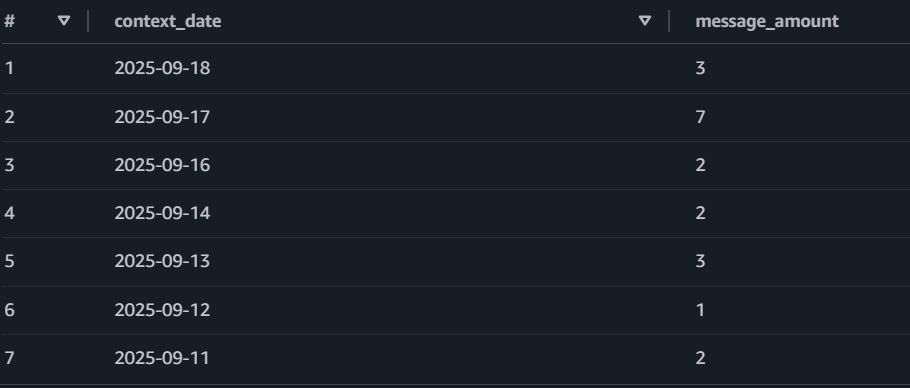

2 - Quantidade de mensagens por usuário por dia.

```sql
SELECT
  user_id,
  user_first_name,
  context_date,
  count(1) AS "message_amount"
FROM "telegram"
GROUP BY
  user_id,
  user_first_name,
  context_date
ORDER BY context_date DESC
```

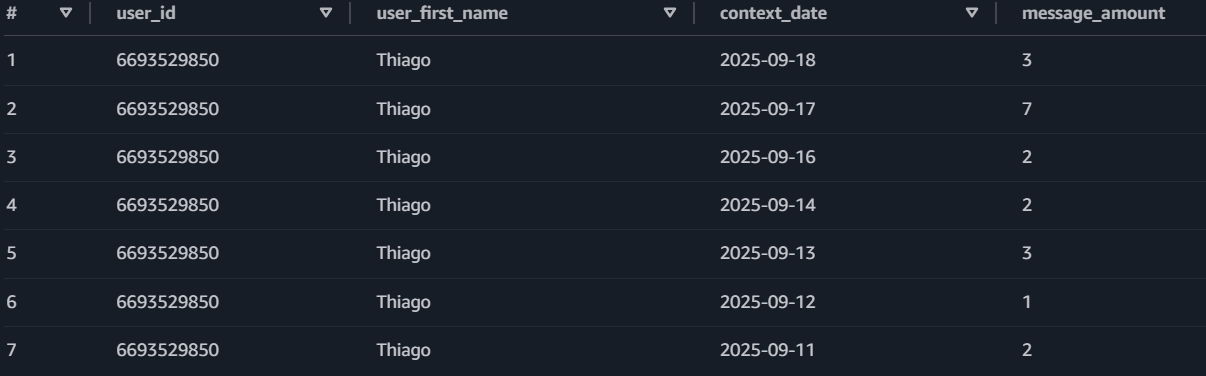

3 - Média do tamanho das mensagens por usuário por dia.
```sql
SELECT
  user_id,
  user_first_name,
  context_date,
  CAST(AVG(length(text)) AS INT) AS "average_message_length"
FROM "telegram"
GROUP BY
  user_id,
  user_first_name,
  context_date
ORDER BY context_date DESC
```

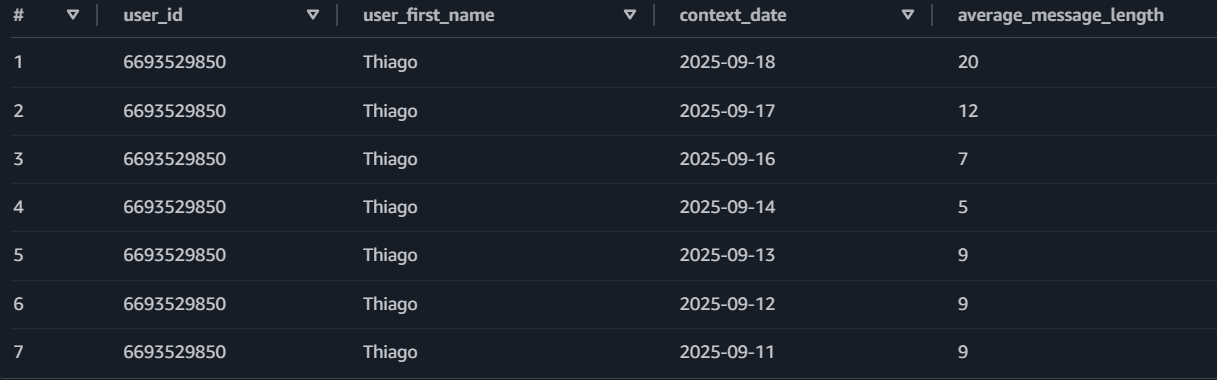

4 - Quantidade de mensagens por hora por dia da semana por número da semana.

```sql
WITH
parsed_date_cte AS (
    SELECT
        *,
        CAST(date_format(from_unixtime("date"),'%Y-%m-%d %H:%i:%s') AS timestamp) AS parsed_date
    FROM "telegram"
),
hour_week_cte AS (
    SELECT
        *,
        EXTRACT(hour FROM parsed_date) AS parsed_date_hour,
        EXTRACT(dow FROM parsed_date) AS parsed_date_weekday,
        EXTRACT(week FROM parsed_date) AS parsed_date_weeknum
    FROM parsed_date_cte
)
SELECT
    parsed_date_hour,
    parsed_date_weekday,
    parsed_date_weeknum,
    count(1) AS "message_amount"
FROM hour_week_cte
GROUP BY
    parsed_date_hour,
    parsed_date_weekday,
    parsed_date_weeknum
ORDER BY
    parsed_date_weeknum,
    parsed_date_weekday
```

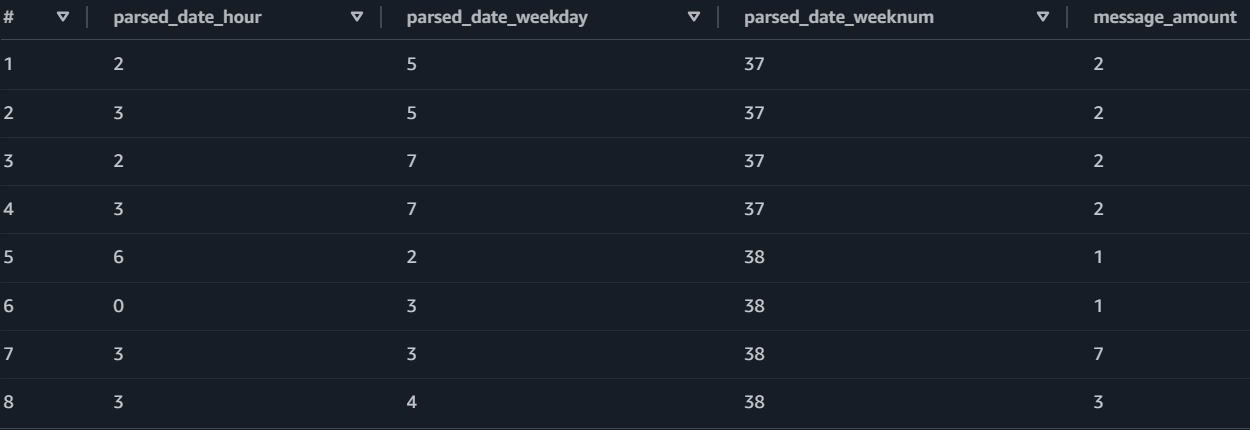